In [1]:
pip install keras-vis

Note: you may need to restart the kernel to use updated packages.


In [2]:
import keras
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import layers
print("keras      {}".format(keras.__version__))
print("tensorflow {}".format(tf.__version__))

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

keras      2.12.0
tensorflow 2.12.0


In [3]:
train_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/train'
val_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/val'
test_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/test'

In [4]:
img_height = 128
img_width = 128
batch_size = 32

In [5]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
train_dir,
color_mode='grayscale',
image_size=(img_height, img_width),
batch_size=batch_size
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
val_dir,
color_mode='grayscale',
image_size=(img_height, img_width),
batch_size=batch_size
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
test_dir,
color_mode='grayscale',
image_size=(img_height, img_width),
batch_size=batch_size
)

Found 5216 files belonging to 2 classes.
Found 16 files belonging to 2 classes.
Found 624 files belonging to 2 classes.


In [6]:
train_ds.class_names

['NORMAL', 'PNEUMONIA']

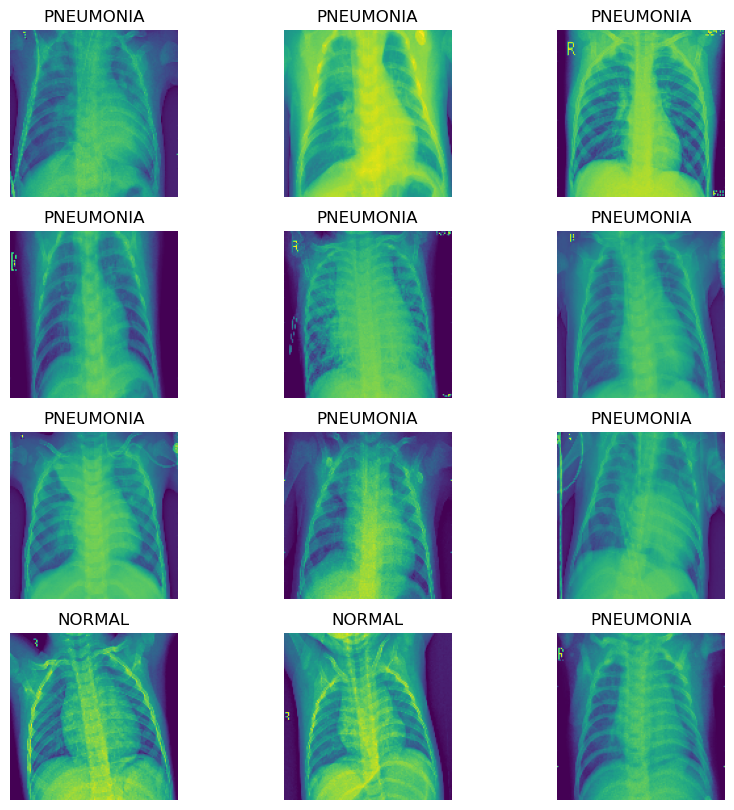

In [7]:
plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
    for i in range(12):
        plt.subplot(4, 3, i + 1)
        plt.imshow(np.squeeze(images[i].numpy().astype('uint8')))
        plt.title(train_ds.class_names[labels[i]])
        plt.axis("off")

In [8]:
pip install pillow tensorflow keras

Note: you may need to restart the kernel to use updated packages.


In [9]:
from tensorflow.keras.preprocessing.image import img_to_array

In [10]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


553467096/553467096 [==============================] - 3s 0us/step


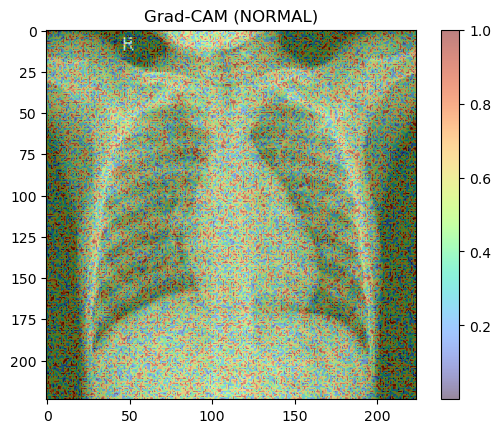

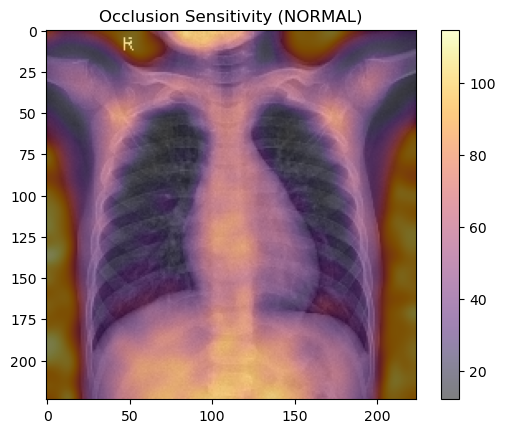

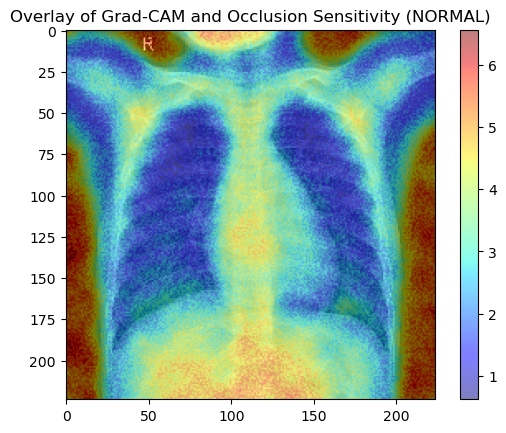

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Model

base_model = VGG16(weights='imagenet')
model = Model(inputs=base_model.input, outputs=base_model.get_layer('block5_conv3').output)

img_path = '/kaggle/input/chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0143-0001.jpeg'
img = load_img(img_path, target_size=(224, 224))
img_array = img_to_array(img)
img_array = preprocess_input(img_array)

YPred = 'NORMAL'

pneumonia_mask = np.random.rand(img_array.shape[0], img_array.shape[1]) < 0.5

def occlusion_sensitivity(model, image, mask):
    occluded_image = image.copy()
    occluded_image[mask] = 0
    sensitivity_map = np.linalg.norm(image - occluded_image, axis=-1)
    
    smoothed_map = gaussian_filter(sensitivity_map, sigma=5)
    return smoothed_map

sensitivity_map = occlusion_sensitivity(model, img_array, pneumonia_mask)

gradcam = np.random.rand(224, 224)

gradcam = gradcam / np.max(gradcam)

cmap_gradcam = 'turbo'  
cmap_sensitivity = 'inferno'  

plt.figure()
plt.imshow(img)
plt.imshow(gradcam, alpha=0.5, cmap=cmap_gradcam, vmin=np.min(gradcam), vmax=np.max(gradcam))
plt.colorbar()
plt.title("Grad-CAM ({})".format(YPred))

plt.figure()
plt.imshow(img)
plt.imshow(sensitivity_map, alpha=0.5, cmap=cmap_sensitivity, vmin=np.min(sensitivity_map), vmax=np.max(sensitivity_map))
plt.colorbar()
plt.title("Occlusion Sensitivity ({})".format(YPred))

weight_gradcam = 0.95  
final_heatmap = weight_gradcam * gradcam + (1 - weight_gradcam) * sensitivity_map

plt.figure()
plt.imshow(img)
plt.imshow(final_heatmap, alpha=0.5, cmap='jet', vmin=np.min(final_heatmap), vmax=np.max(final_heatmap))
plt.colorbar()
plt.title("Overlay of Grad-CAM and Occlusion Sensitivity ({})".format(YPred))

plt.show()
